# Lanczos basics: tridiagonalization, Green's function, and spectral density

This notebook demonstrates the core utilities in `hydroglass.lanczos`:

- `lanczos_tridiagonal`: build a Krylov basis and a symmetric tridiagonal.
- `haydock_greens_function`: evaluate the continued-fraction Green's function.
- `haydock_spectral_density`: compute the spectral density from the imaginary part.

We run on a small random symmetric test matrix so results can be compared to exact diagonalization. The same workflow applies to large or sparse operators.

Key points:
- The **Haydock spectral density** (continued fraction) must match the **spectral measure of the tridiagonal T** built from `(alpha, beta)` to numerical precision.
- Agreement with the **full matrix** spectrum requires either `M ≈ N` or a moderate broadening `ETA`.


In [13]:
# Parameters (edit here)
N = 20  # dimension of the test matrix
M = 20  # number of Lanczos steps (depth)
ETA = 1e-2  # positive imaginary shift for the Green's function
SEED = 7  # RNG seed for reproducibility
USE_SPARSE = False  # set True to use scipy.sparse if available

# Optionally scale the matrix so its spectrum sits comfortably in a target radius
AUTO_SCALE = False  # set True to rescale A to have spectral radius ~ TARGET_RADIUS

TARGET_RADIUS = 2.5  # only used when AUTO_SCALE is True

# Omega grid resolution; the range will be derived from the Ritz values of T
NOMEGA = 8001  # more points for sharper peaks when ETA is small

# Toggle saving the figure
SAVE_FIG = False
FIG_PATH = "lanczos_spectral_density.pdf"

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigvalsh
from numpy import trapezoid  # modern replacement for np.trapz

from hydroglass.lanczos import (
    lanczos_tridiagonal,
    tridiagonal_eigh,
    haydock_greens_function,
    haydock_spectral_density,
)

try:
    import scipy.sparse as sp

    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

rng = np.random.default_rng(SEED)


def make_symmetric_matrix(n: int, seed: int) -> np.ndarray:
    rng_local = np.random.default_rng(seed)
    A = rng_local.normal(size=(n, n))
    A = 0.5 * (A + A.T)
    return A


def maybe_sparse(A: np.ndarray, use_sparse: bool):
    if use_sparse and SCIPY_OK:
        return sp.csr_matrix(A)
    return A


def normalize(x: np.ndarray) -> np.ndarray:
    nrm = float(np.linalg.norm(x))
    if nrm == 0.0 or not np.isfinite(nrm):
        raise ValueError("Cannot normalize a zero or nonfinite vector.")
    return x / nrm


def build_T(alpha: np.ndarray, beta: np.ndarray) -> np.ndarray:
    m = alpha.size
    T = np.zeros((m, m), dtype=float)
    np.fill_diagonal(T, alpha)
    if m > 1:
        T[np.arange(m - 1), np.arange(1, m)] = beta
        T[np.arange(1, m), np.arange(m - 1)] = beta
    return T


def lorentzian_sum(
    omega_grid: np.ndarray, centers: np.ndarray, weights: np.ndarray, eta: float
) -> np.ndarray:
    og = omega_grid[:, None]
    ck = centers[None, :]
    wk = weights[None, :]
    return (wk * (1.0 / np.pi) * eta / ((og - ck) ** 2 + eta**2)).sum(axis=1)

## Build a test operator, optionally rescale, and run Lanczos

We create a random symmetric matrix `A_dense`, optionally rescale it to fit in a target spectral radius, choose a random normalized starting vector `v0`, and run Lanczos.

In [15]:
# Dense test operator
A_dense = make_symmetric_matrix(N, seed=SEED)

if AUTO_SCALE:
    # Rescale A so that its spectral radius is ~ TARGET_RADIUS
    evals_full = eigvalsh(A_dense)
    radius = float(np.max(np.abs(evals_full)))
    if radius > 0.0:
        scale = TARGET_RADIUS / radius
        A_dense = A_dense * scale
        print(f"Rescaled A by factor {scale:.3g} so radius ~ {TARGET_RADIUS}")

A = maybe_sparse(A_dense, USE_SPARSE)

# Starting vector v0
v0 = normalize(rng.normal(size=N))

# Lanczos tridiagonalization
alpha, beta, V = lanczos_tridiagonal(
    matrix_or_linear_operator=A,
    initial_vector=v0,
    num_steps=M,
    reorthogonalization="partial",
    atol_reorth=1e-12,
)

print(f"alpha shape: {alpha.shape}, beta shape: {beta.shape}, V shape: {V.shape}")

alpha shape: (20,), beta shape: (19,), V shape: (20, 20)


## Choose omega grid from the Ritz values of T

We derive the frequency window from the eigenvalues of the tridiagonal `T`. This ensures the integral of the spectral density is close to one (assuming the window covers the spectrum and `v0` is normalized).

In [16]:
theta = tridiagonal_eigh(alpha, beta)
pad = 10.0 * ETA
OMEGA_MIN = float(theta.min() - pad)
OMEGA_MAX = float(theta.max() + pad)
omega = np.linspace(OMEGA_MIN, OMEGA_MAX, int(NOMEGA))
print(f"omega range: [{OMEGA_MIN:.3f}, {OMEGA_MAX:.3f}] with {omega.size} points")

omega range: [-5.966, 5.234] with 8001 points


## Green's function, spectral density, and references

- `rho_cf`: Haydock continued fraction result.
- `rho_T`: exact spectral measure of the tridiagonal `T` (should match `rho_cf`).
- `rho_full`: Lorentzian sum over all eigenpairs of the full matrix (will match closely only if `M ≈ N` or broadening is large).

In [17]:
# Continued fraction evaluation
G = haydock_greens_function(alpha=alpha, beta=beta, omega=omega, eta=ETA)
rho_cf = haydock_spectral_density(alpha=alpha, beta=beta, omega=omega, eta=ETA)

# Tridiagonal reference (exact for the continued fraction)
T = build_T(alpha, beta)
theta_T, U_T = np.linalg.eigh(T)
w_T = U_T[0, :] ** 2
rho_T = lorentzian_sum(omega, theta_T, w_T, ETA)

# Full matrix reference (all eigenpairs)
evals_full, Q_full = np.linalg.eigh(A_dense)  # single call to align eigenpairs
coeff = Q_full.T @ v0
w_full = np.abs(coeff) ** 2
rho_full = lorentzian_sum(omega, evals_full, w_full, ETA)

# Diagnostics
print("N =", A_dense.shape[0], " M =", alpha.size)
print("max |rho_cf - rho_T|   =", float(np.max(np.abs(rho_cf - rho_T))))
print("max |rho_cf - rho_full| =", float(np.max(np.abs(rho_cf - rho_full))))
print("Integral of rho_cf =", float(trapezoid(rho_cf, omega)))

N = 20  M = 20
max |rho_cf - rho_T|   = 1.6227019727921288e-12
max |rho_cf - rho_full| = 5.053735208093713e-13
Integral of rho_cf = 0.9841620710697894


## Plots

Top: spectral densities compared.
Bottom: real and imaginary parts of the Green's function from the Haydock continued fraction.

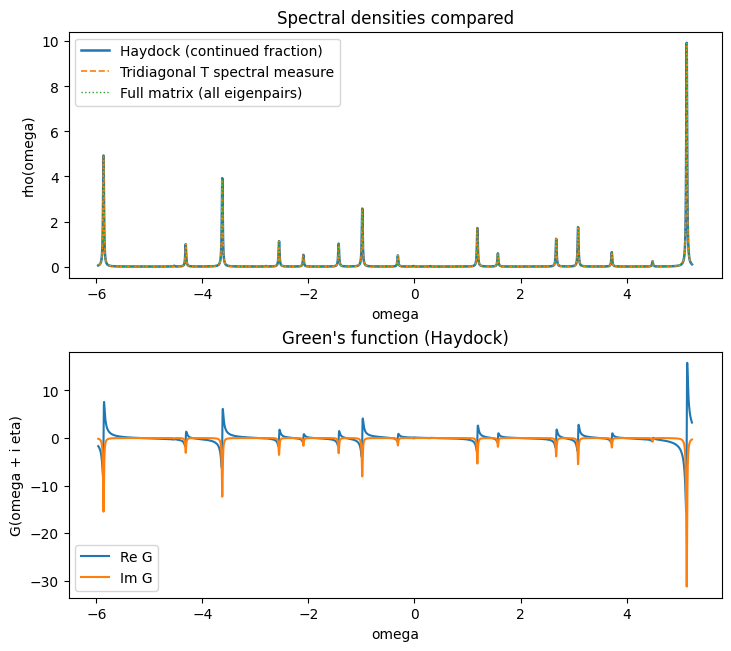

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7.2, 6.4), constrained_layout=True)

ax1.plot(omega, rho_cf, label="Haydock (continued fraction)", lw=1.8)
ax1.plot(omega, rho_T, label="Tridiagonal T spectral measure", lw=1.2, ls="--")
ax1.plot(omega, rho_full, label="Full matrix (all eigenpairs)", lw=1.0, ls=":")
ax1.set_xlabel("omega")
ax1.set_ylabel("rho(omega)")
ax1.set_title("Spectral densities compared")
ax1.legend()

ax2.plot(omega, np.real(G), label="Re G", lw=1.5)
ax2.plot(omega, np.imag(G), label="Im G", lw=1.5)
ax2.set_xlabel("omega")
ax2.set_ylabel("G(omega + i eta)")
ax2.set_title("Green's function (Haydock)")
ax2.legend()

if SAVE_FIG:
    fig.savefig(FIG_PATH, dpi=200)